# Comparison of MLP and Bayes NN on MNIST dataset

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import zhusuan as zs

import numpy as np
import matplotlib.pyplot as plt
import mnist
import time

tf.set_random_seed(123)
np.random.seed(321)

/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

### Load data

In [2]:

train_X = mnist.train_images()[:5000]
train_X = train_X.reshape(train_X.shape[0], -1) / 255.
train_y_ = mnist.train_labels()[:5000]

test_X = mnist.test_images()[:50]
test_X = test_X.reshape(test_X.shape[0], -1) / 255.
test_y_ = mnist.test_labels()[:50]

n_train, x_dim = train_X.shape
n_test = test_X.shape[0]
y_dim = 10

train_y = tf.keras.utils.to_categorical(train_y_, y_dim)
test_y = tf.keras.utils.to_categorical(test_y_, y_dim)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((5000, 784), (5000, 10), (50, 784), (50, 10))

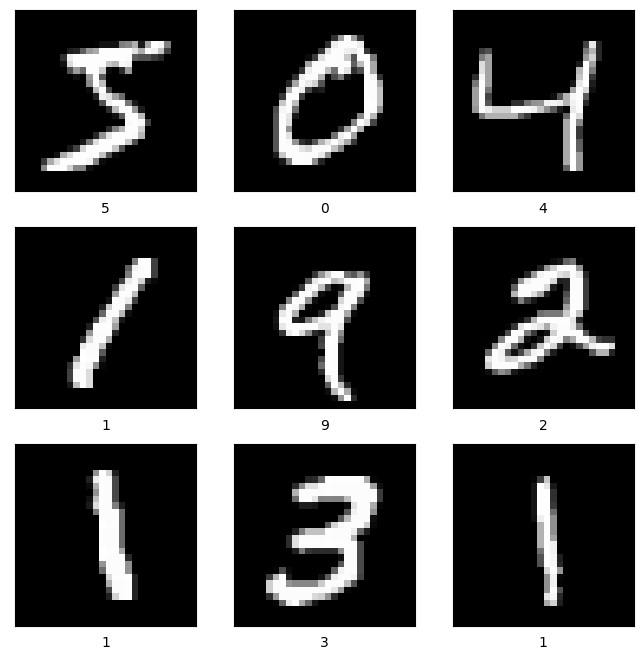

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(train_X[i].reshape(28, 28), cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=np.argmax(train_y[i]))
plt.show()

## Standarize data

In [4]:
def standardize(data_train, data_test):
    """
    Standardize a dataset to have zero mean and unit standard deviation.

    :param data_train: 2-D Numpy array. Training data.
    :param data_test: 2-D Numpy array. Test data.

    :return: (train_set, test_set, mean, std), The standardized dataset and
        their mean and standard deviation before processing.
    """
    std = np.std(data_train, 0, keepdims=True)
    std[std == 0] = 1
    mean = np.mean(data_train, 0, keepdims=True)
    data_train_standardized = (data_train - mean) / std
    data_test_standardized = (data_test - mean) / std
    mean, std = np.squeeze(mean, 0), np.squeeze(std, 0)
    return data_train_standardized, data_test_standardized, mean, std

In [5]:
train_X_standard, test_X_standard, _, _ = standardize(train_X, test_X)

### Defintion of parameters

In [6]:
n_hiddens = [32, 32]
layer_sizes = [x_dim] + n_hiddens + [y_dim]

epochs = 50
lr = 0.005
batch_size = 100 

### MLP model

In [7]:
mlp = Sequential()
mlp.add(Dense(layer_sizes[1], activation="relu", input_shape=(x_dim,)))
for out_dim in layer_sizes[2:-1]:
    mlp.add(Dense(out_dim, activation="relu"))
mlp.add(Dense(y_dim, activation="softmax"))

optimizer = Adam(lr=lr)
mlp.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
mlp.build()
mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [8]:
training_results = mlp.fit(
                            x=train_X_standard,
                            y=train_y,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(test_X_standard, test_y),
                        )

Train on 5000 samples, validate on 50 samples
Instructions for updating:
Use tf.cast instead.


2023-12-30 21:43:34.519162: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-12-30 21:43:34.539132: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2023-12-30 21:43:34.539478: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55d32ccf95b0 executing computations on platform Host. Devices:
2023-12-30 21:43:34.539504: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/50
5000/5000 [==============================] - 0s 68us/sample - loss: 0.6786 - acc: 0.7928 - val_loss: 0.2492 - val_acc: 0.9000
Epoch 2/50
5000/5000 [==============================] - 0s 24us/sample - loss: 0.2103 - acc: 0.9394 - val_loss: 0.2402 - val_acc: 0.9400
Epoch 3/50
5000/5000 [==============================] - 0s 27us/sample - loss: 0.1294 - acc: 0.9604 - val_loss: 0.2761 - val_acc: 0.9400
Epoch 4/50
5000/5000 [==============================] - 0s 24us/sample - loss: 0.0888 - acc: 0.9736 - val_loss: 0.3278 - val_acc: 0.9200
Epoch 5/50
5000/5000 [==============================] - 0s 25us/sample - loss: 0.0541 - acc: 0.9852 - val_loss: 0.3480 - val_acc: 0.9400
Epoch 6/50
5000/5000 [==============================] - 0s 27us/sample - loss: 0.0304 - acc: 0.9946 - val_loss: 0.3525 - val_acc: 0.9200
Epoch 7/50
5000/5000 [==============================] - 0s 23us/sample - loss: 0.0188 - acc: 0.9964 - val_loss: 0.3031 - val_acc: 0.9200
Epoch 8/50
5000/5000 [===================

5000/5000 [==============================] - 0s 28us/sample - loss: 0.0202 - acc: 0.9954 - val_loss: 0.3380 - val_acc: 0.9400
Epoch 21/50
5000/5000 [==============================] - 0s 26us/sample - loss: 0.0121 - acc: 0.9982 - val_loss: 0.3410 - val_acc: 0.9600
Epoch 22/50
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0085 - acc: 0.9988 - val_loss: 0.2532 - val_acc: 0.9400
Epoch 23/50
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0044 - acc: 0.9998 - val_loss: 0.2802 - val_acc: 0.9400
Epoch 24/50
5000/5000 [==============================] - 0s 26us/sample - loss: 0.0038 - acc: 0.9998 - val_loss: 0.2693 - val_acc: 0.9400
Epoch 25/50
5000/5000 [==============================] - 0s 28us/sample - loss: 0.0036 - acc: 0.9998 - val_loss: 0.2669 - val_acc: 0.9400
Epoch 26/50
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0036 - acc: 0.9998 - val_loss: 0.2639 - val_acc: 0.9400
Epoch 27/50
5000/5000 [=======================

In [9]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.xlim([0, 20])
    # plt.ylim(ylim)
    # Tailor x-axis tick marks
    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

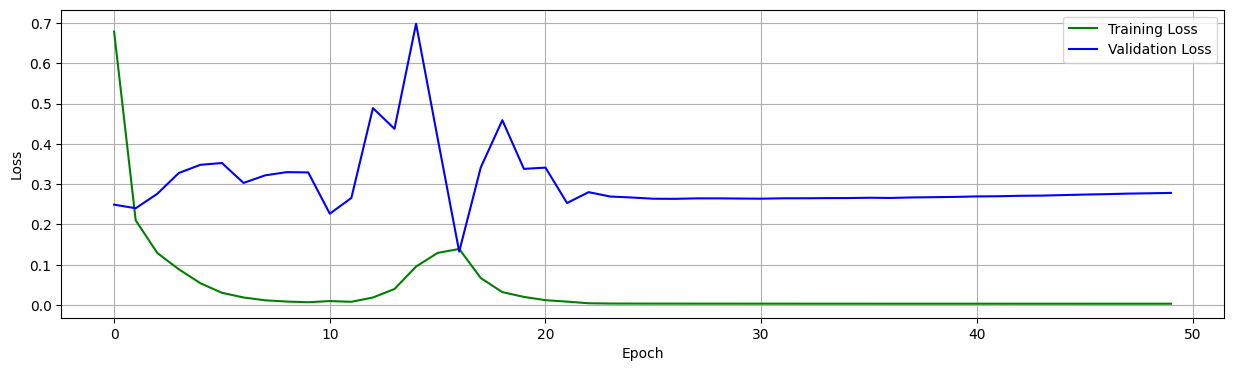

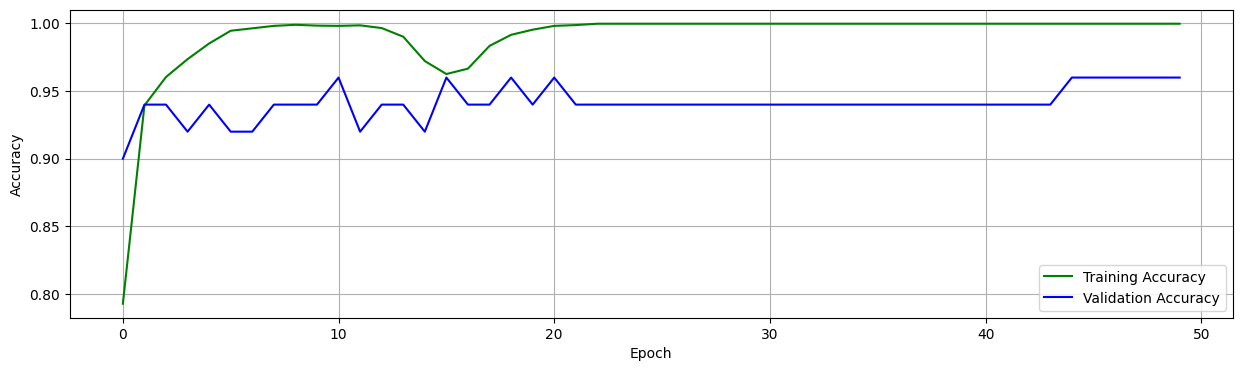

In [10]:
train_loss = training_results.history["loss"]
valid_loss = training_results.history["val_loss"]
train_acc  = training_results.history["acc"]
valid_acc  = training_results.history["val_acc"]

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

### Bayes NN model

In [11]:
train_y = train_y_
test_y = test_y_

In [12]:
lr=0.08

In [13]:
@zs.meta_bayesian_net(scope="bnn", reuse_variables=True)
def build_bnn(x, layer_sizes, n_particles):
    bn = zs.BayesianNet()
    h = tf.tile(x[None, ...], [n_particles, 1, 1])
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w = bn.normal("w" + str(i), tf.zeros([n_out, n_in + 1]), std=1.,
                      group_ndims=2, n_samples=n_particles)
        h = tf.concat([h, tf.ones(tf.shape(h)[:-1])[..., None]], -1)
        h = tf.einsum("imk,ijk->ijm", w, h) / tf.sqrt(
            tf.cast(tf.shape(h)[2], tf.float32))
        if i < len(layer_sizes) - 2:
            h = tf.nn.relu(h)

    y = bn.categorical('y', h)
    bn.deterministic('y_logit', h)
    return bn

In [14]:
@zs.reuse_variables(scope="variational")
def build_mean_field_variational(layer_sizes, n_particles):
    bn = zs.BayesianNet()
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w_mean = tf.get_variable(
            "w_mean_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        w_logstd = tf.get_variable(
            "w_logstd_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        bn.normal("w" + str(i), w_mean, logstd=w_logstd,
                  n_samples=n_particles, group_ndims=2)
    return bn

In [15]:
n_particles = tf.placeholder(tf.int32, shape=[], name='n_particles')
x = tf.placeholder(tf.float32, shape=(None, x_dim))
y = tf.placeholder(tf.int32, shape=(None))

w_names = ["w" + str(i) for i in range(len(layer_sizes) - 1)]

x_obs = tf.tile(tf.expand_dims(x, 0), [n_particles, 1, 1])
y_obs = tf.tile(tf.expand_dims(y, 0), [n_particles, 1])

In [16]:
model = build_bnn(x, layer_sizes, n_particles)
variational = build_mean_field_variational(layer_sizes, n_particles)

def log_joint(bn):
    log_pe = bn.cond_log_prob(w_names)
    log_py_xe = bn.cond_log_prob('y')
    return tf.add_n(log_pe) + tf.reduce_mean(log_py_xe, 1) * n_train

model.log_joint = log_joint

lower_bound = zs.variational.elbo(model, {'y': y_obs},
                                    variational=variational, axis=0)

In [17]:
y_logit = lower_bound.bn["y_logit"]
h_pred = tf.reduce_mean(tf.nn.softmax(y_logit), 0)
y_pred = tf.argmax(h_pred, 1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(lower_bound.sgvb()) / n_train
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
infer = optimizer.minimize(cost)

In [18]:
lower_bound = tf.reduce_mean(lower_bound) / n_train

params = tf.trainable_variables()
for i in params:
    print('variable name = {}, shape = {}'
            .format(i.name, i.get_shape()))

variable name = dense/kernel:0, shape = (784, 32)
variable name = dense/bias:0, shape = (32,)
variable name = dense_1/kernel:0, shape = (32, 32)
variable name = dense_1/bias:0, shape = (32,)
variable name = dense_2/kernel:0, shape = (32, 10)
variable name = dense_2/bias:0, shape = (10,)
variable name = Adam/iterations:0, shape = ()
variable name = Adam/lr:0, shape = ()
variable name = Adam/beta_1:0, shape = ()
variable name = Adam/beta_2:0, shape = ()
variable name = Adam/decay:0, shape = ()
variable name = training/Adam/Variable:0, shape = (784, 32)
variable name = training/Adam/Variable_1:0, shape = (32,)
variable name = training/Adam/Variable_2:0, shape = (32, 32)
variable name = training/Adam/Variable_3:0, shape = (32,)
variable name = training/Adam/Variable_4:0, shape = (32, 10)
variable name = training/Adam/Variable_5:0, shape = (10,)
variable name = training/Adam/Variable_6:0, shape = (784, 32)
variable name = training/Adam/Variable_7:0, shape = (32,)
variable name = training/Ad

In [19]:
lb_samples = 10
ll_samples = 3000
epochs = 40
batch_size = 10
iters = (n_train-1) // batch_size + 1
test_batch_size = 10
test_iters = (n_test-1) // test_batch_size + 1
test_freq = 5

In [20]:
train_accs = []
test_accs= []

train_lbs = []
test_lbs = []


# Run the inference
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        time_epoch = -time.time()
        indices = np.random.permutation(n_train)
        train_X_standard = train_X_standard[indices]
        train_y = train_y[indices]
        lbs = []
        correct = 0
        for t in range(iters):
            x_batch = train_X_standard[t * batch_size:(t + 1) * batch_size]
            y_batch = train_y[t * batch_size:(t + 1) * batch_size]
            _, lb = sess.run(
                [infer, lower_bound],
                feed_dict={n_particles: lb_samples,
                            x: x_batch, y: y_batch})
            lbs.append(lb)
            if epoch % test_freq == 0 or epoch == 0:
                train_acc1 = sess.run(
                    [acc],
                    feed_dict={n_particles: ll_samples,
                                x: x_batch, y: y_batch})
                correct += train_acc1[0] * len(x_batch)
        if epoch % test_freq == 0 or epoch == 0:
            train_accs.append(correct / n_train)

        time_epoch += time.time()
        train_lb = np.mean(lbs)
        train_lbs.append(train_lb)
        print('Epoch {} ({:.1f}s): Lower bound = {}'.format(
            epoch, time_epoch, train_lb))

        if epoch % test_freq == 0 or epoch == 0:
            time_test = -time.time()
            test_lbs_batch = []
            correct = 0
            for t in range(test_iters):
                x_batch = test_X_standard[t * test_batch_size:(t + 1) * test_batch_size]
                y_batch = test_y[t * test_batch_size:(t + 1) * test_batch_size]
                lb, acc1 = sess.run(
                    [lower_bound, acc],
                    feed_dict={n_particles: ll_samples,
                                x: x_batch, y: y_batch})
                test_lbs_batch.append(lb)
                correct += acc1 * len(x_batch)
            time_test += time.time()
            test_acc = correct / n_test
            test_accs.append(test_acc)
            test_lbs.append(np.mean(test_lbs_batch))
            # print('>>> TEST ({:.1f}s)'.format(time_test))
            # print('>> Test lower bound = {}'.format(np.mean(test_lbs_batch)))
            # print('>> Test accuracy = {}'.format(test_acc))


Epoch 1 (5.2s): Lower bound = -1.871300220489502
Epoch 2 (4.6s): Lower bound = -1.4842414855957031
Epoch 3 (5.0s): Lower bound = -1.4274264574050903
Epoch 4 (4.0s): Lower bound = -1.393070101737976
Epoch 5 (342.0s): Lower bound = -1.40250825881958
Epoch 6 (4.0s): Lower bound = -1.3906848430633545
Epoch 7 (4.0s): Lower bound = -1.3985522985458374
Epoch 8 (4.0s): Lower bound = -1.3812307119369507
Epoch 9 (4.0s): Lower bound = -1.4076887369155884
Epoch 10 (350.2s): Lower bound = -1.3728652000427246
Epoch 11 (4.1s): Lower bound = -1.3727130889892578
Epoch 12 (4.1s): Lower bound = -1.3920029401779175
Epoch 13 (4.2s): Lower bound = -1.366149663925171
Epoch 14 (4.1s): Lower bound = -1.385610580444336
Epoch 15 (345.5s): Lower bound = -1.360927939414978
Epoch 16 (4.0s): Lower bound = -1.362442135810852
Epoch 17 (4.1s): Lower bound = -1.3611598014831543
Epoch 18 (4.0s): Lower bound = -1.352279782295227
Epoch 19 (4.0s): Lower bound = -1.345792531967163
Epoch 20 (343.1s): Lower bound = -1.38202810

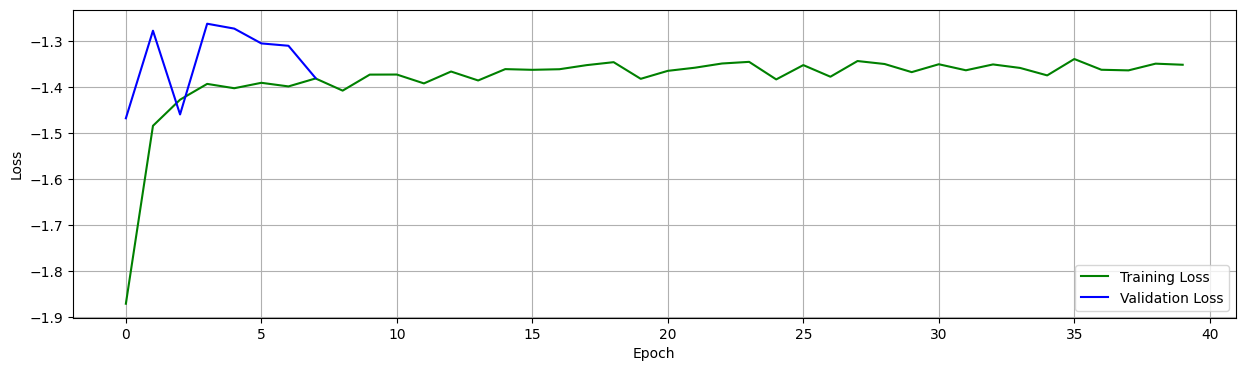

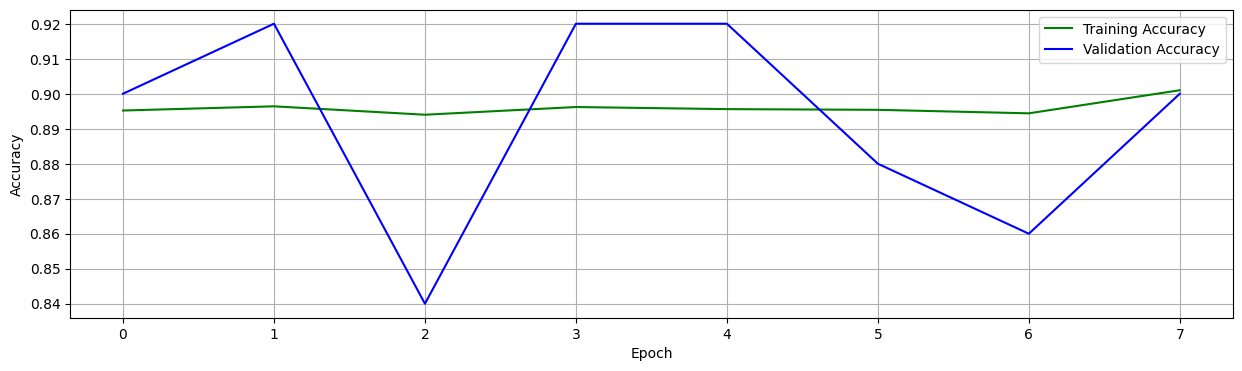

In [21]:
plot_results([ train_lbs, test_lbs ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"])

plot_results([ train_accs, test_accs ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])